# Import and functions

In [49]:
import os
import pandas as pd
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
import glob
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def convert_pdf_to_txt(path, maxpages=0):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text


def plot_as_word_cloud(labels, filenames_short):
    wordclouds=[]
    for label in set(labels):
        label_files = [x[1] for x in zip(labels,filenames_short) if x[0]==label]
        wordcloud = WordCloud(background_color="white", max_font_size=40).generate(" ".join(label_files))
        wordclouds.append(wordcloud.to_image())

    n = int(np.ceil(np.sqrt(len(wordclouds))))
    plt.rcParams['figure.figsize'] = [10,8]
    plt.subplots_adjust(wspace=.02, hspace=.02)
    for i, wordcloud in enumerate(wordclouds):
        _ = plt.subplot(n, n, i+1)
        _ = plt.imshow(wordclouds[i])
        _ = plt.axis('off')
        
        
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    

# Extract features

In [4]:
root_dir = r"pdf_cluster"
texts = []
files = []

vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1, 1), max_features=1024)

for filename in glob.iglob(os.path.join(root_dir, "**"), recursive=True):
    if filename.endswith(".pdf"):
#         print(filename)
        texts.append(convert_pdf_to_txt(filename, maxpages=1))
        files.append(filename)

X = vectorizer.fit_transform(texts)
with open('data.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump({"data": X, "vectorizer": vectorizer}, file)
  

In [15]:
files

['pdf_cluster\\auto companies\\en-wikipedia-org-wiki-Apple_Inc-.pdf',
 'pdf_cluster\\auto companies\\en-wikipedia-org-wiki-Audi.pdf',
 'pdf_cluster\\auto companies\\en-wikipedia-org-wiki-Ducati_Motor_Holding.pdf',
 'pdf_cluster\\auto companies\\en-wikipedia-org-wiki-Hewlett-Packard.pdf',
 'pdf_cluster\\auto companies\\en-wikipedia-org-wiki-Mercedes-Benz.pdf',
 'pdf_cluster\\auto companies\\en-wikipedia-org-wiki-NSU_Motorenwerke.pdf',
 'pdf_cluster\\auto companies\\en-wikipedia-org-wiki-Suzuki.pdf',
 'pdf_cluster\\auto companies\\en-wikipedia-org-wiki-Vespa.pdf',
 'pdf_cluster\\auto companies\\en-wikipedia-org-wiki-Volkswagen.pdf',
 'pdf_cluster\\auto companies\\en_wikipedia_org_wiki_Bajaj_Auto.pdf',
 'pdf_cluster\\auto companies\\en_wikipedia_org_wiki_BMW.pdf',
 'pdf_cluster\\auto companies\\en_wikipedia_org_wiki_Hero_MotoCorp.pdf',
 'pdf_cluster\\auto companies\\en_wikipedia_org_wiki_Honda.pdf',
 'pdf_cluster\\auto companies\\en_wikipedia_org_wiki_KTM.pdf',
 'pdf_cluster\\auto compani

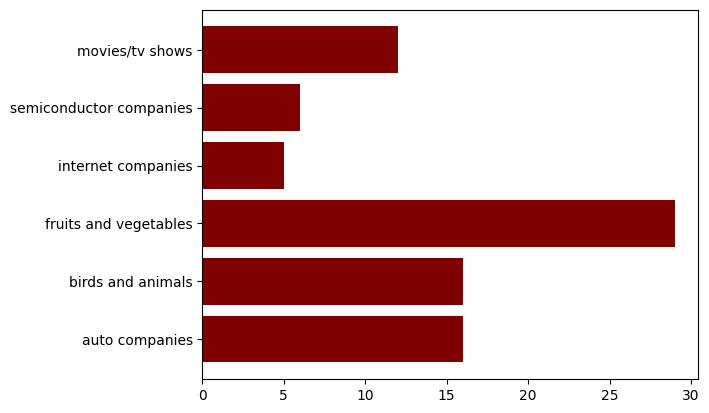

In [32]:
count=[16, 16, 29, 5, 6, 12]
title=['auto companies', 'birds and animals', 'fruits and vegetables', 'internet companies', 'semiconductor companies', 'movies/tv shows']
tmp=plt.barh(title, count, color ='maroon')

In [18]:
# d=cosine_similarity(X)
# plt.imshow(np.sqrt(np.sqrt(np.sqrt(d))))

In [44]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
indices = [0]+list(np.cumsum(count))


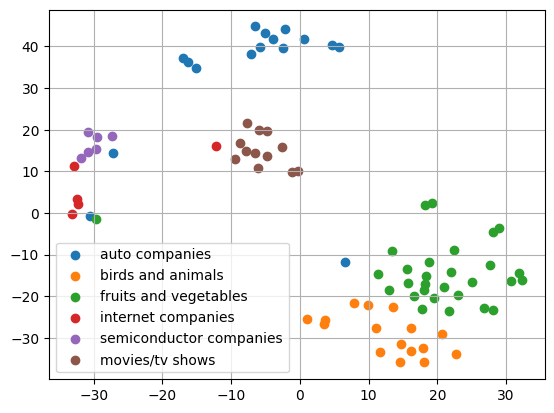

In [47]:
for i in range(len(indices)-1):
    plt.scatter(X_embedded[indices[i]:indices[i+1],0], X_embedded[indices[i]:indices[i+1],1])
plt.grid()  
plt.legend(title, loc='lower left')


# Load features and cluster

In [36]:
with open('data.pkl', 'rb') as file:
    data = pickle.load(file)
X, vectorizer = data['data'], data['vectorizer']


In [ ]:
# plt.figure(figsize=(12,10))
# df = pd.DataFrame(data = X.toarray())
# cor = df.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

# Agglomerative Clustering

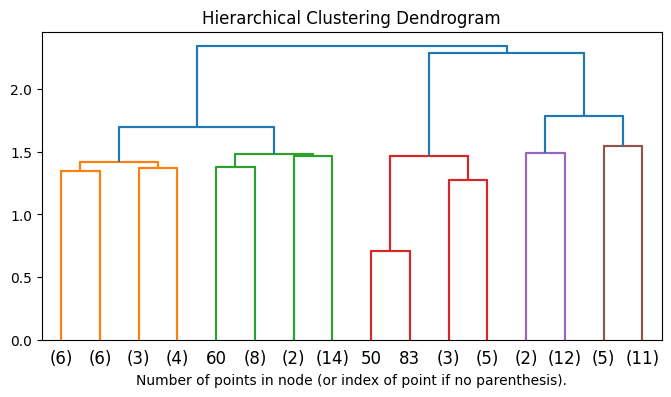

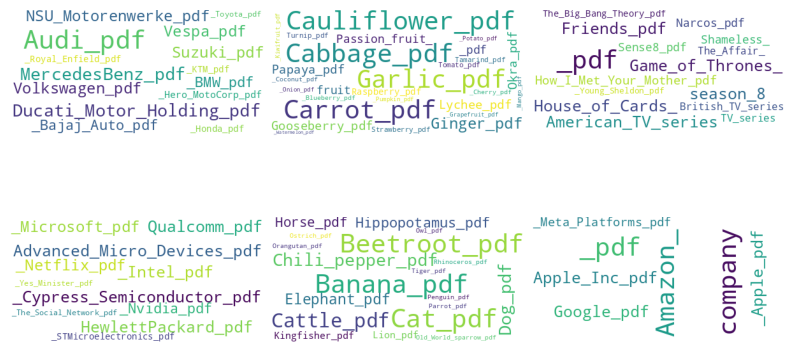

In [19]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
Y = clustering.fit(X.toarray())
plt.rcParams['figure.figsize'] = [8, 4]
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level", p=3)
plot_dendrogram(clustering, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# clustering = DBSCAN(eps=3, min_samples=1)
# clustering = AgglomerativeClustering(affinity='cosine', linkage='single')
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
Y = clustering.fit(X.toarray())
labels = Y.labels_
filenames_short = [f.split("wiki")[-1].replace("-", "").replace(".", "_") for f in files]
# Save and visualize
df = pd.DataFrame(list(zip(Y.labels_, files)), columns=['label', 'filename'])
plot_as_word_cloud(labels, filenames_short)
df.to_csv("results.csv")


In [16]:
# clustering = AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=None, distance_threshold=0)
# Y = clustering.fit(X.toarray())
# plt.rcParams['figure.figsize'] = [8, 4]
# plt.title("Hierarchical Clustering Dendrogram")
# plot_dendrogram(clustering, truncate_mode="level", p=3)
# plot_dendrogram(clustering, truncate_mode="level", p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

# # clustering = DBSCAN(eps=3, min_samples=1)
# # clustering = AgglomerativeClustering(affinity='cosine', linkage='single')
# clustering = AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=None, distance_threshold=14)
# Y = clustering.fit(X.toarray())
# labels = Y.labels_
# filenames_short = [f.split("wiki")[-1].replace("-", "").replace(".", "_") for f in files]
# # Save and visualize
# df = pd.DataFrame(list(zip(Y.labels_, files)), columns=['label', 'filename'])
# plot_as_word_cloud(labels, filenames_short)
# df.to_csv("results.csv")


# K Means Elbow Method

In [58]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 50)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X.toarray(), kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X.toarray(), kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

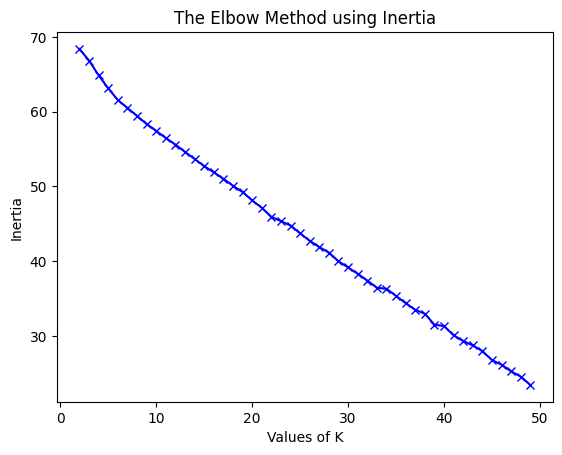

In [59]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


# Final model

In [17]:
with open('clustering.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump({"model": clustering}, file)
  